# Tech assessment DuckDuckGoose - RWVOS

The idea of this assessment is to incorporate all elements of a deep learning pipeline:
1. Exploring the dataset
2. Optional pre-processing and cleaning of the dataset, if necessary
3. Find the best model for the task 

Don't forget to activate the GPU available through Google Colab. If you have a GPU on your local computer, good for you. Just don't forget to use it. 

We do encourage you to use Pytorch, as this is the library mostly used by DuckDuckGoose, but if you are fare more skilled in Tensorflow and want to show off these skills 🤩, don't hestitate to do so. 

Also: we do not expect you to train a model that has 100% accuracy on a test set. This assignment is for you to figure out if you like to work with this kind of data and for us to see if there is a general understanding of the requirements for the eventual project you'll work on 😃

After receiving the assessment, you have 48 hours to complete it. Instruction on how to hand in your work are provided at the bottom on the notebook.

## Introduction to the topic: fake faces!
As you are aware, DuckDuckGoose is concerned with the problem of deepfake detection. Over the years, deepfakes have become harder to distinguish due to risen quality of hardware and software. Luckily for you, there is a dataset with some "old" fake faces to practice!

The task for you is to do a binary classification: are these faces real or fake?

## The dataset 
You can find the dataset here: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection. The dataset contais roughly 2000 images. We alreay splitted it into train, validation and test sets for you (how nice of us). Per folder, it is divided into two folders: real and fake images.  

You can choose how you want to do the assignment: locally, in a notebook, Google Colab. Completely up to you.

For demonstration purposes, we show how the images look like through a Google Colab implementation. 

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl

from torchvision import transforms, models
from PIL import Image

from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# check GPU 
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("cpu")
    


C:\Users\Reinier Vos\anaconda3\envs\torch182\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GeForce GTX 1660 Ti


In [2]:
using_colab = False

if using_colab:
    checkpoint_dir = "own_1_run"
    import shutil
    from google.colab import drive, files
    drive.mount('/content/drive', force_remount=True)
    !git clone https://github.com/rwvosTUD/techAss.git
    tbzip_folder="/content/{0}_z.zip".format(checkpoint_dir)
    zip_folder = "/content/{0}".format(checkpoint_dir)
    real = "/content/drive/MyDrive/detection_dataset/train/real/"
    fake = "/content/drive/MyDrive/detection_dataset/train/fake/"
    import techAss.utilityV1 as util
else:
    real = "detection_dataset/train/real/"
    fake = "detection_dataset/train/fake/"
    import utilityV1 as util
real_path = os.listdir(real)
fake_path = os.listdir(fake)

## Chapter 1: Data analysis

### Section 1.1: visual inspection

real images


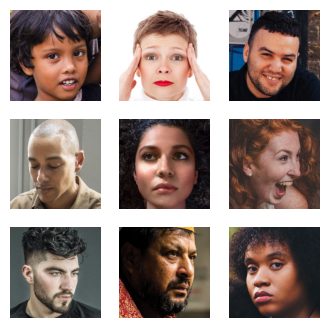

fake images


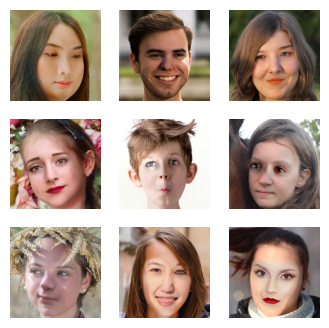

In [3]:
print("real images")
fig = plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(util.load_img(real + real_path[i]), cmap='gray')    
    plt.axis('off')
plt.show()

print("fake images")
fig = plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(util.load_img(fake + fake_path[i]), cmap='gray')    
    plt.axis('off')
plt.show()

### Section 1.2: Dataset inspection

Label ratios to check for imbalance during training

In [4]:
n_real = len(real_path)
n_fake = len(fake_path)
threshold = n_fake/(n_fake+n_real)
print("Data set division = real/fake = {0}/{1} = {2} %".format(n_real,n_fake,round(threshold*100,1)))

Data set division = real/fake = 864/768 = 47.1 %


Conclusion: training set is slightly imbalanced, yet not considerably. However benchmark of model should not be considered at 50%.

## Chapter 2: Pre-processing the dataset 




The dataset contains real and fake images. It might be possible any form of exploration is desired, to find some important aspects of the images and to see if there is any pre-processing needed: do you want transformations, a certain size? Remind you: not required at all! But do think about this and be able to explain your choices. 

To stimulate the use of Pytorch, we created a Dataset object which can easily be used in combination with the Dataloader. 

You can adapt this with your own transformations, processing etc. You can adjust the size of the image if you want to, colours etc: all up to you!

### Section 2.1: Setup dataloader instances

In [5]:
if using_colab:
    dir_name = "/content/drive/MyDrive/detection_dataset/" 
else:
    dir_name = "./detection_dataset/"

dataset_train = util.RealOrFakeDataset(dir_name, "train")
data_train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = util.RealOrFakeDataset(dir_name, "val")
data_val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

dataset_test= util.RealOrFakeDataset(dir_name, "test")
data_test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

sample,label = next(iter(data_train_loader))
sample.shape # RGB (224x224)

torch.Size([32, 3, 224, 224])

## Chapter 3: Neural networks definitions

## Section 3.1: Simple neural network
<br> design choices:
- Convolution layers + ReLU
- Max pooling

In [6]:
class NeuralNet(nn.Module):
    '''
    This class contains all functions required for 
    a custom neural network architecture
    '''
    
    def __init__(self, use_batchnorm = False, use_dropout = False):
        '''
        todo
        '''
        super(NeuralNet, self).__init__()
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
        self.conv1 = nn.Conv2d(3,16,3)
        self.mp1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        
        self.conv_bn1=nn.BatchNorm2d(16)
        self.conv_bn2=nn.BatchNorm2d(32)
        
        self.dropout1=nn.Dropout(p = 0.2)
        self.dropout2=nn.Dropout(p = 0.2)
        
        #'''
        self.fc1 = nn.Linear(64*26*26, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        #'''

    def forward(self,x):
        x = self.mp1(F.relu(self.conv1(x)))
        if self.use_batchnorm:
            x = self.conv_bn1(x)
        x = self.mp1(F.relu(self.conv2(x)))
        if self.use_batchnorm:
            x = self.conv_bn2(x)
        x = self.mp1(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        #'''
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        if self.use_dropout:
            x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.squeeze(x)
        #x = self.fc3(x)
        #'''
        return x

summary(NeuralNet(use_batchnorm = True, use_dropout = True), (3,224,224), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 222, 222]        448
├─MaxPool2d: 1-2                         [-1, 16, 111, 111]        --
├─BatchNorm2d: 1-3                       [-1, 16, 111, 111]        32
├─Conv2d: 1-4                            [-1, 32, 109, 109]        4,640
├─MaxPool2d: 1-5                         [-1, 32, 54, 54]          --
├─BatchNorm2d: 1-6                       [-1, 32, 54, 54]          64
├─Conv2d: 1-7                            [-1, 64, 52, 52]          18,496
├─MaxPool2d: 1-8                         [-1, 64, 26, 26]          --
├─Linear: 1-9                            [-1, 128]                 5,537,920
├─Dropout: 1-10                          [-1, 128]                 --
├─Linear: 1-11                           [-1, 64]                  8,256
├─Dropout: 1-12                          [-1, 64]                  --
├─Linear: 1-13                           [-1, 32]                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 222, 222]        448
├─MaxPool2d: 1-2                         [-1, 16, 111, 111]        --
├─BatchNorm2d: 1-3                       [-1, 16, 111, 111]        32
├─Conv2d: 1-4                            [-1, 32, 109, 109]        4,640
├─MaxPool2d: 1-5                         [-1, 32, 54, 54]          --
├─BatchNorm2d: 1-6                       [-1, 32, 54, 54]          64
├─Conv2d: 1-7                            [-1, 64, 52, 52]          18,496
├─MaxPool2d: 1-8                         [-1, 64, 26, 26]          --
├─Linear: 1-9                            [-1, 128]                 5,537,920
├─Dropout: 1-10                          [-1, 128]                 --
├─Linear: 1-11                           [-1, 64]                  8,256
├─Dropout: 1-12                          [-1, 64]                  --
├─Linear: 1-13                           [-1, 32]                  

## Section 3.2: Existing neural network architecture
<br> design choices:
- Pretrained ResNet50 with retrained classifier layers
- 

In [ ]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # We only need the image feature so we can cut off the classifier
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        for layer in self.resnet.parameters():
            layer.requires_grad = False
        '''
        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        #'''
        #'''
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        #'''
    
    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x,1)
        #'''
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = torch.squeeze(x)
        #'''
        #x = x.squeeze()
        #x = nn.functional.normalize(x, p=2, dim=1)
        return x
    
#summary(ResNetModel(), (3,224,224), device = device)

## Chapter 4: Model training and validation
<br> Models performnance is tracked using tensorboard
<br>Details:
- Binary cross entropy loss function
- Metrics tracked:
    - Classification accuracy
    - f
    - f 
- f

In [7]:
# Configuration details
own_model = True # set false for resnet
epochs = 300

In [8]:
# Create a writer to write to tensorboard
writer = SummaryWriter()

# Inititiate model and optimizers
if own_model:
    net = NeuralNet(use_batchnorm = True, use_dropout = True).to(device)
else:
    net = ResNetModel().to(device)
criterion = nn.BCELoss() # binary cross entropy
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# initiate loss containers
train_metrics_np = np.zeros((epochs,5))
test_metrics_np = np.zeros((epochs,5))

for e in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss, train_metrics = util.train_epoch(device, data_train_loader,net,optimizer,criterion, threshold)
    train_loss = train_loss.cpu().detach().item() 
    
    # Test on data
    test_loss, test_metrics = util.test_epoch(device, data_val_loader,net,criterion, threshold)
    test_loss = test_loss.cpu().detach().item() 
    
    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss, 'Test':test_loss}, e)            
    writer.add_scalars('Accuracy', {'Train': train_metrics["accuracy"],'Test':test_metrics["accuracy"]} , e)
    writer.add_scalars('Precision', {'Train': train_metrics["precision"],'Test':test_metrics["precision"]} , e)
    writer.add_scalars('Recall', {'Train': train_metrics["recall"],'Test':test_metrics["recall"]} , e)
    writer.add_scalars('F1', {'Train': train_metrics["F1"],'Test':test_metrics["F1"]} , e)

    # save metrics
    train_metrics_np[e,:] = [train_loss, train_metrics["accuracy"],train_metrics["precision"],
                             train_metrics["recall"],train_metrics["F1"]]
    test_metrics_np[e,:] = [test_loss, test_metrics["accuracy"],test_metrics["precision"],
                            test_metrics["recall"],test_metrics["F1"]]
    
    print("Epoch-{0} accuracy: {1}".format(e,train_metrics["accuracy"]))

if using_colab:
    # https://stackoverflow.com/questions/52444921/save-numpy-array-using-pickle

    fileName1 = "{}_train_df".format(checkpoint_dir)
    fileObject1 = open(fileName1, 'wb')
    pkl.dump(train_metrics_np, fileObject1)
    fileObject1.close()
    
    fileName2 = "{]_test_df".format(checkpoint_dir)
    fileObject2 = open(fileName2, 'wb')
    pkl.dump(test_metrics_np, fileObject2)
    fileObject2.close()
    
    shutil.copy("{}_train_df.pkl".format(checkpoint_dir), "/content/drive/MyDrive") # save result to drive
    shutil.copy("{}_train_df.pkl".format(checkpoint_dir), "/content/drive/MyDrive") # save result to drive
    print("Zip file created, saved next run")


    
print('Finished Training')
writer.flush()
writer.close()

  0%|▍                                                                              | 1/200 [00:17<58:25, 17.61s/it]

Epoch-0 accuracy: 0.5294117647058824


  0%|▍                                                                            | 1/200 [00:25<1:23:54, 25.30s/it]


KeyboardInterrupt: 

Tensorboard code, run in console

In [ ]:
# !tensorboard --logdir runs/ --host localhost

In [ ]:

train_metrics_np

In [ ]:
train_losses2 = []
train_accs2 = []
test_losses2 = []
test_accs2 = []
for i in range(epochs):
    train_losses2.append(train_losses[i].cpu().detach().item())
    #train_accs2.append(train_accs[i].cpu().detach().item())
    test_losses2.append(test_losses[i].cpu().detach().item())
    #test_accs2.append(test_accs[i].cpu().detach().item())
    
    
epochs_array = np.arange(epochs)

plt.figure(1)
plt.plot(epochs_array, train_losses2)


plt.figure(2)
plt.plot(epochs_array, train_accs)

plt.figure(3)
plt.plot(epochs_array, test_losses2)

plt.figure(4)
plt.plot(epochs_array, test_accs)



# === Assignment description ===

## Models 

Your task is to implement at least two different models:
1. Create a small neural network. Just a few layers. Create the neural network architecture yourself and code it yourself (using PyTorch or Tensorflow ofcourse). 
2. Choose 1 or 2 existing model architectures.  

The goal is to train all networks and compare performances on the test set. 

For the neural network, it is allowed to use already existing code (no need to re-invent the wheel). But again: be able to explain the reason behind it. Why are you using ReLU instead of sigmoid? Why are you using a batch normalisation layer or add drop-out?

Think about the metrics you would like to use: is it accuracy, F1-score, AMP? Or a combinations of a few metrics?

### Comparison
In order to know which model is most suited for the dataset, you have to compare the models in some way. Visually, numerically: does not matter, as long as you can argument your choice. 

## Bonus: creativity required!
Some questions we would like you to think about and dig in the corners of your mind. You do not have to put your creative hurdles into action; we are just interested in any mind-blowing solutions you can think of.

### Question 1: if you had **unlimited** resources (think about 100 GPU's, 40GB each), what would be the best model for this task? How would you pick this model?

### Question 2: is **more** data always better?

### Question 3: could you name a task that we would not be able to solve with DL?

#Deliverable
Send your notebook, Colab or code back to your contact person at DuckDuckGoose. We will contact you to schedule a demo. You are free to decide on the format of the demo.